In [1]:
from astropy.table import Table
import numpy as np
from scipy import interpolate
from scipy.optimize import curve_fit
from astropy.io import ascii
import matplotlib.pyplot as plt
import datetime
import numbers
# from scipy.integrate import quad

# Time range around the horizon crossing
startTime = 390+1.92224*10**8
stopTime = 500+1.92224*10**8

# indices of full crossing
startTimeIndex = 311869
stopTimeIndex = 449115

startMKF = 2264 - 15 #exact start at -18...missing some data points before
stopMKF = 2374 + 184

# read in the data files
tabMKF = Table.read('ni2200300102.mkf', hdu=1)
timeMKF = np.array(tabMKF['TIME'][startMKF:stopMKF])
elevMKF = np.array(tabMKF['ELV'][startMKF:stopMKF])
ramMKF = np.array(tabMKF['RAM_ANGLE'][startMKF:stopMKF])
pointing_unit = np.array(tabMKF['PNTUNIT'][startMKF:stopMKF])
position = np.array(tabMKF['POSITION'][startMKF:stopMKF])
position_mag = np.array(np.sqrt((position[:,0])**2+(position[:,1])**2+(tabMKF['POSITION'][startMKF:stopMKF][:,2])**2))
velocity = np.array(tabMKF['VELOCITY'][startMKF:stopMKF])
velocity_mag = np.array(np.sqrt((velocity[:,0])**2+(velocity[:,1])**2+(velocity[:,2])**2))
# make unit vectors
for col in range(3):
    velocity[:,col] = velocity[:,col]/velocity_mag
    position[:,col] = position[:,col]/position_mag
pole_vec = np.cross(position,velocity)

# calculate orbital phase angle
ascending_node = np.cross(pole_vec, [0,0,1])
ascending_mag = np.sqrt(ascending_node[:,0]**2 + ascending_node[:,1]**2)
for col in range(3):
    ascending_node[:,col] = ascending_node[:,col]/ascending_mag
orbital_phase = np.rad2deg(np.arccos(ascending_node[:,0]*position[:,0] + ascending_node[:,1]*position[:,1] + ascending_node[:,2]*position[:,2]))
# It has to be p cross z, or else we are not moving away from the ascending node

R = 6378
H = 419
theta = np.arcsin(R/(R+H))
beta = elevMKF + np.rad2deg(theta)

#Tangent altitude of line of sight is based on elevation angle
altMKF = []
for indx, val in enumerate(elevMKF):
    h = (((R+H)*np.sin(theta+val*(np.pi/180)))-R)
    altMKF.append(h)
altMKF = np.array(altMKF)
betaMKF = np.rad2deg(np.arcsin((R+altMKF)/(R+H)))

tabEVT = Table.read('cleanfilt.evt', hdu=1)
eventTime = np.array(tabEVT['TIME'][startTimeIndex:stopTimeIndex])
enArray = np.array(tabEVT['PI'][startTimeIndex:stopTimeIndex])

# We have to sync up the two data files
def Interpolator(col_mkf):
    f = interpolate.interp1d(timeMKF, col_mkf, kind='linear')
    return f(eventTime)

elev_evt = Interpolator(elevMKF)
ram_evt = Interpolator(ramMKF)
Xcoord = Interpolator(position[:,0])
Ycoord = Interpolator(position[:,1])
Zcoord = Interpolator(position[:,2])
phase_evt = Interpolator(orbital_phase)

# calculate tangent altitude based on elevation angle
altArray = []
for indx, val in enumerate(elev_evt):
    h = (((R+H)*np.sin(theta+val*(np.pi/180)))-R)
    altArray.append(np.float(h))
altArray = np.array(altArray)
#beta = np.arcsin((R+altArray)/(R+H))


# read in MSIS model data
data = ascii.read("msis_419.txt")

height = np.array(data['h'])
density = np.array(data['dens'])
temp = np.array(data['T'])


def msisSync(Y_msis):
    height[0] = altArray[0]
    height[len(height)-1] = altArray[len(altArray)-1]
    func = interpolate.interp1d(height, Y_msis)
    return np.array(func(altArray))


msisRho = msisSync(density)
msisT = msisSync(temp)

In [2]:
# constants
binSize_all = 1
k = 1.38064852e-23
mu = 28
mp = 1.6726219e-27
g = 9.8
# L = (k*T)/(1000*mu*mp*g)
z0 = 135
# p0 = 0.0012*np.exp(-z0/L)


class EnergyBands:

    def __init__(self, energy_band, bin_size):
        self.energy_band = energy_band
        self.bin_size = bin_size
        self.time, self.energies = EnergyBands.enSplit(self)
        self.new_alt, self.elev, self.phase = EnergyBands.altSplit(self)
        self.rate, self.binnedElev, self.new_alt, self.binTime, self.binnedEnergy, self.binnedX, self.binnedY, self.binnedZ, self.binnedPhase = EnergyBands.countRate(self)
        self.T_pre = EnergyBands.msisSplit(self, msisT)
        self.rho_pre = EnergyBands.msisSplit(self, msisRho)
        self.rho_msis, self.T_msis = EnergyBands.countRateSync(self)
        self.perc_trans = EnergyBands.percTrans(self)
        self.sigmafit_popt, self.sigmafit_pcov = EnergyBands.modelFit_sigma(self)

        
    def altSplit(self):
        index = np.where((enArray >= self.energy_band[0]) & (
            enArray < self.energy_band[1]))
        return altArray[index[0]], elev_evt[index[0]], phase_evt[index[0]]

    # function that deduces the number of counts per bin size
    def countRate(self):
        binCounts = []
        binTime = []
        altitude = []
        binnedEnergy = []
        binnedX = []
        binnedY = []
        binnedZ = []
        binElev = []
        binnedPhase = []
        for i in np.arange(min(self.time), max(self.time)+self.bin_size, self.bin_size):
            desind = np.where((self.time >= i) & (self.time < i + self.bin_size))
            if len(desind[0]) != 0:
                binCounts.append(np.size(desind[0]))
                altitude.append(np.mean(self.new_alt[desind[0]]))
                binTime.append(np.mean(self.time[desind[0]]))
                binnedEnergy.append(np.mean(self.energies[desind[0]]))
                binnedX.append(np.mean(Xcoord[desind[0]]))
                binnedY.append(np.mean(Ycoord[desind[0]]))
                binnedZ.append(np.mean(Zcoord[desind[0]]))
                binElev.append(np.mean(self.elev[desind[0]]))
                binnedPhase.append(np.mean(self.phase[desind[0]]))
        return np.array(binCounts), np.array(binElev), np.array(altitude), np.array(binTime), np.array(binnedEnergy), np.array(binnedX), np.array(binnedY), np.array(binnedZ), np.array(binnedPhase)

    def msisSplit(self, msis_col):
        index = np.where((enArray >= self.energy_band[0]) & (enArray < self.energy_band[1]))
        return msis_col[index[0]]

    def countRateSync(self):
        rho = []
        temp = []
        for i in np.arange(min(self.time), max(self.time)+self.bin_size, self.bin_size):
            desind = np.where((self.time >= i) & (self.time < i + self.bin_size))
            if len(desind[0]) != 0:
                rho.append(np.mean(self.rho_pre[desind[0]]))
                temp.append(np.mean(self.T_pre[desind[0]]))
        return np.array(rho), np.array(temp)

    # function that makes a list of times corresponding to each energy range
    def enSplit(self):
        index = np.where((enArray >= self.energy_band[0]) & (
            enArray < self.energy_band[1]))
        return eventTime[index[0]], enArray[index[0]]/100

    def percTrans(self):
        plateau = np.where(((self.new_alt > 250) & (self.new_alt < 300)))
        avg = np.mean(self.rate[plateau[0]])
        return (self.rate/avg)*100
    
    @property
    def normFactor(self):
        plateau = np.where(((self.new_alt > 250) & (self.new_alt < 300)))
        avg = np.mean(self.rate[plateau[0]])
        return avg

    # functions for the atmospheric model
    @property
    def atmHeight(self):
        return np.array((k*self.T_msis)/(1000*mu*mp*g))
  
    def Z_x(self, hi, x):
        z = np.int(np.sqrt((R+self.new_alt[hi])**2+x**2)-R)
        if z > (len(self.new_alt)-1):
            return len(self.new_alt)-1
        else:
            return z
    
    def Transmit2(self, Alt, sigma):
        tau = []
        halfDist = np.sqrt((R+H)**2-(R+self.new_alt)**2)
        for hi in range(len(self.new_alt)):
            g = 0
            intStepSize = 1
            upperBound1 = halfDist[hi]
            X1 = np.arange(0, upperBound1, intStepSize)
            for n in X1:
                g += self.rho_msis[hi]*intStepSize*10**5 #EnergyBands.Z_x(self, hi, n)

            tau.append(2*sigma*g)
        tau = np.array(tau)
        trans = np.exp(-tau)
        return trans*self.normFactor
    
    def modelFit_sigma(self):
        popt, pcov = curve_fit(self.Transmit2, self.new_alt, self.rate)
        return popt, pcov

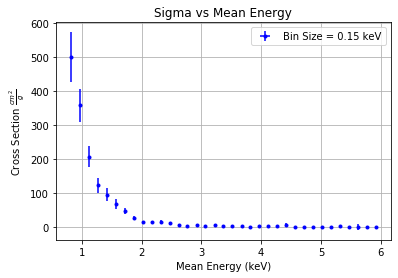

In [3]:
#Energy bands
width = 15 #0.15 keV
for val in np.arange(75, 600, width):
    locals()["EnRange"+str(val)] = [val, val+width]
    locals()["En"+str(val)] = EnergyBands(locals()["EnRange"+str(val)], binSize_all)


sigmalist = []
sigmaError = []
energylist = []


for val in np.arange(75, 600, width):
    sigmalist.append(locals()["En"+str(val)].sigmafit_popt)
    sigmaError.append(locals()["En"+str(val)].sigmafit_pcov)
    energylist.append(np.mean(locals()["En"+str(val)].binnedEnergy))
    

yerr = []
for val in sigmaError:
    yerr.append(np.sqrt(val[0][0]))
    
xerr = np.zeros(len(yerr))

plt.errorbar(energylist, sigmalist, xerr=xerr, yerr=yerr, fmt='b.', label='Bin Size = 0.15 keV')
plt.title('Sigma vs Mean Energy')
plt.xlabel('Mean Energy (keV)')
plt.ylabel(r'Cross Section $\frac{cm^2}{g}$')
plt.grid()
plt.legend()

In [4]:
sigma1D = []
sigmaError1D = []
for i in range(len(sigmalist)):
    sigma1D.append(sigmalist[i][0])
    sigmaError1D.append(sigmaError[i][0][0])
    
sigma1D = np.array(sigma1D)
energylist = np.array(energylist)
sigmaError1D = np.array(np.sqrt(sigmaError1D))

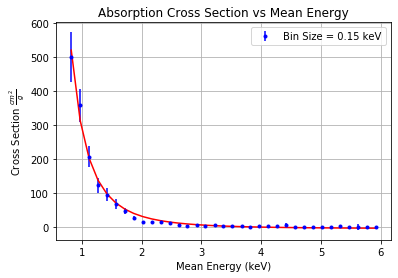

In [6]:
def negCube(energy, a, b):
    c = np.float(-3)
    return a*energy**c + b

%matplotlib inline
plt.errorbar(energylist, sigma1D, yerr=sigmaError1D, fmt='b.', label='Bin Size = 0.15 keV')
popt, pcov = curve_fit(negCube, energylist, sigma1D)
plt.plot(energylist, negCube(energylist, *popt), 'r-')
plt.title('Absorption Cross Section vs Mean Energy')
plt.xlabel('Mean Energy (keV)')
plt.ylabel(r'Cross Section $\frac{cm^2}{g}$')
plt.grid()
plt.legend()

In [7]:
pcov

array([[24.09983107, -4.01907652],
       [-4.01907652,  3.76535556]])

In [8]:
popt

array([292.89518769,  -5.76781894])

In [9]:
from scipy.stats import chisquare
chisquare(sigma1D, negCube(energylist, *popt))

Power_divergenceResult(statistic=-31.49617006463309, pvalue=1.0)